Links to previous EDA work:
(The findings in these were less relevant, but I did create some files that will serve as the starting point for this notebook)

- eda1, general exploration of the full, original datase, mostly consists of histograms comparing reorders : all orders feature-by-feature: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda1_w_data_direct_from_wrangling.ipynb

- eda2, creating new rows so that each order contains all newly-ordered items and reorders plus record of all items not re-ordered this time for the biggest user. Generally exploring some of this user's purchasing practices: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/eda2_single_user.ipynb

In [1]:
# ! pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import collections

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

from library.sb_utils import save_file
import json

In [3]:
# Get df with practice user's orders (includes rows for non-reorders)
df = pd.read_csv('../data/processed/practice_user.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34021 entries, 0 to 34020
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                34021 non-null  int64  
 1   user_id                 34021 non-null  int64  
 2   order_by_user_sequence  34021 non-null  int64  
 3   order_dow               34021 non-null  int64  
 4   order_hour_of_day       34021 non-null  int64  
 5   days_since_prior_order  33995 non-null  float64
 6   product_id              34021 non-null  int64  
 7   add_to_cart_sequence    1992 non-null   float64
 8   reordered               34021 non-null  float64
 9   product_name            34021 non-null  object 
 10  aisle_name              34021 non-null  object 
 11  dept_name               34021 non-null  object 
 12  aisle_id                34021 non-null  float64
 13  department_id           34021 non-null  float64
 14  eval_set                1992 non-null 

In [4]:
# Drop the irrelevant eval_set column
df = df.drop(columns = 'eval_set')
df.head()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id
0,2959648,32099,1,0,17,NaN,40285,18.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,125.0,19.0
1,2959648,32099,1,0,17,NaN,27966,15.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,123.0,4.0
2,2959648,32099,1,0,17,NaN,34969,16.0,0.0,Red Vine Tomato,fresh vegetables,produce,83.0,4.0
3,2959648,32099,1,0,17,NaN,7419,12.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,83.0,4.0
4,2959648,32099,1,0,17,NaN,26209,9.0,0.0,Limes,fresh fruits,produce,24.0,4.0


In [5]:
# Get dictionaries connecting product-aisle-dept

with open('../data/processed/dicts/aisle_dept_dict.txt', 
          'r') as ad_file:
     ad_dict = json.load(ad_file)

with open('../data/processed/dicts/prod_aisle_dict.txt', 
          'r') as pa_file:
     pa_dict = json.load(pa_file)
        
with open('../data/processed/dicts/dept_id_name_dict.txt', 
          'r') as dd_file:
     dd_dict = json.load(dd_file)
        
with open('../data/processed/dicts/aisle_id_name_dict.txt', 
          'r') as aa_file:
     aa_dict = json.load(aa_file)
        
with open('../data/processed/dicts/prod_id_name_dict.txt', 
          'r') as pp_file:
     pp_dict = json.load(pp_file)
        
dd_dict

{'7': 'beverages',
 '16': 'dairy eggs',
 '19': 'snacks',
 '17': 'household',
 '4': 'produce',
 '14': 'breakfast',
 '13': 'pantry',
 '20': 'deli',
 '1': 'frozen',
 '11': 'personal care',
 '12': 'meat seafood',
 '6': 'international',
 '3': 'bakery',
 '15': 'canned goods',
 '9': 'dry goods pasta',
 '5': 'alcohol',
 '8': 'pets',
 '18': 'babies',
 '2': 'other',
 '21': 'missing',
 '10': 'bulk'}

In [6]:
# Fix dictionary to make the keys int rather than str

pp_dict = {int(k):v for k,v in pp_dict.items()}
aa_dict = {int(k):v for k,v in aa_dict.items()}
dd_dict = {int(k):v for k,v in dd_dict.items()}
pa_dict = {int(k):v for k,v in pa_dict.items()}
ad_dict = {int(k):v for k,v in ad_dict.items()}

dd_dict

{7: 'beverages',
 16: 'dairy eggs',
 19: 'snacks',
 17: 'household',
 4: 'produce',
 14: 'breakfast',
 13: 'pantry',
 20: 'deli',
 1: 'frozen',
 11: 'personal care',
 12: 'meat seafood',
 6: 'international',
 3: 'bakery',
 15: 'canned goods',
 9: 'dry goods pasta',
 5: 'alcohol',
 8: 'pets',
 18: 'babies',
 2: 'other',
 21: 'missing',
 10: 'bulk'}

In the initial notebooks I was just playing around and really exploring to see what data exists. Here, work to actually do what it would take to make predictions about this user's reorders, before moving into feature engineering on a bigger portion of the full dataset.

Questions to answer:
- Given an order of a product by a person (here, this person; later many users), what is the likelihood that they will reorder it ever? How soon will they order it again, and again? 
- How might I make new features that indicate specific reorder practices i.e. not just "this is a reorder" but "this is a reorder, and it's this person's Nth time reordering the item" or "up until now, this person has reordered this item in p percent of all their orders."
- In addition to the reorder column, what meaningful features can be engineered from other existing features (i.e: Column for 0/1 for whether product name contains "organic.")
- What methods are best to use for engineering of features, getting dummies, etc?
- Which models might be best for predicting this one user's reorders? What can I infer about whether similar methods will be useful on a dataset with more users?

In [7]:
# What portion of items that this person orders once, 
# do they reorder, ever? First, find reordered products.

products = set(df['product_name'].unique())
reordered_ever = set(df[df['reordered']==1]['product_name'].unique())
len(reordered_ever)

250

In [8]:
# Find items that are never reordered.

reordered_never = products - reordered_ever
len(reordered_never)

269

Now, find products reordered twice, thrice, etc. Then, make a column that gives the total reorder count at each given reorder. This will help understand reorder practices and will be a useful column later on for feature engineering, as well. 

Start with finding total orders, as that's easy. Then, copy the "reorders" column because if the value is 0 there then the value in the "reorders_so_far" will also be 0, and values can start at 1 early in the "order_by_user_sequence" with 1 added for every subsequent reorder.

In [9]:
# Getting the total reorders is easy

tot_reorders = df[['product_name', 'reordered']].groupby(
    'product_name', as_index=False).sum()

tot_reorders.sort_values('reordered', ascending=False)

,product_name,reordered
90,Coconut Blended Greek Yogurt,46.0
455,Strawberry on the Bottom Nonfat Greek Yogurt,45.0
295,Non Fat Black Cherry on the Bottom Greek Yogurt,44.0
368,Pineapple on the Bottom Greek Yogurt,42.0
8,2% Reduced Fat Milk,39.0
...,...,...
222,Imported Unsalted Butter,0.0
219,Ice Cream Light Chocolate Chip,0.0
218,Ibuprofen Tablets,0.0
216,Honey Vanilla Chamomile Caffeine-Free Herbal Tea,0.0


In [10]:
# ok so this person is constantly buying greek yogurt lol
# almost every-other order (they made 100 orders)

df['tot_reorders'] = tot_reorders.loc[:,'reordered']
df.head()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,tot_reorders
0,2959648,32099,1,0,17,NaN,40285,18.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,125.0,19.0,0.0
1,2959648,32099,1,0,17,NaN,27966,15.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,123.0,4.0,0.0
2,2959648,32099,1,0,17,NaN,34969,16.0,0.0,Red Vine Tomato,fresh vegetables,produce,83.0,4.0,2.0
3,2959648,32099,1,0,17,NaN,7419,12.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,83.0,4.0,7.0
4,2959648,32099,1,0,17,NaN,26209,9.0,0.0,Limes,fresh fruits,produce,24.0,4.0,3.0


In [11]:
# Now, the trickier part is to show, for each item in each reorder,
# how many times the item has been reordered already.

df['reorders_so_far'] = df.loc[:,'reordered']
df.head()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,tot_reorders,reorders_so_far
0,2959648,32099,1,0,17,NaN,40285,18.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,125.0,19.0,0.0,0.0
1,2959648,32099,1,0,17,NaN,27966,15.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,123.0,4.0,0.0,0.0
2,2959648,32099,1,0,17,NaN,34969,16.0,0.0,Red Vine Tomato,fresh vegetables,produce,83.0,4.0,2.0,0.0
3,2959648,32099,1,0,17,NaN,7419,12.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,83.0,4.0,7.0,0.0
4,2959648,32099,1,0,17,NaN,26209,9.0,0.0,Limes,fresh fruits,produce,24.0,4.0,3.0,0.0


In [12]:
# For order_by_user_sequence 1-2, at least, the "reorders_so_far"
# column is already accurate. What will it take to add 1 to the 
# first items that get reordered twice?

reordered2 = set(df[(df['order_by_user_sequence']==2) & 
                   (df['reordered']==1)]['product_name'])
reordered2

{'Large Organic Omega3 Brown Eggs'}

In [13]:
reordered3 = set(df[(df['order_by_user_sequence']==3) & 
                   (df['reordered']==1)]['product_name'])
reordered3

{'Classic Hummus',
 'Coconut Blended Greek Yogurt',
 'European Cucumber',
 'Iceberg Lettuce',
 'Lime Sparkling Water',
 'Organic Raspberries',
 'Thick Bacon'}

In [14]:
# No items reordered in both orders 2 and 3, try 4

reordered4 = set(df[(df['order_by_user_sequence']==4) & 
                   (df['reordered']==1)]['product_name'])
reordered4

{'Black Forest Ham',
 'Blueberry on the Bottom Nonfat Greek Yogurt',
 'Bread, Sliced, Extra Sourdough',
 'Coconut Blended Greek Yogurt',
 'Coke Classic',
 'Corn Chips',
 'European Cucumber',
 'Non Fat Black Cherry on the Bottom Greek Yogurt',
 'Organic Boneless Skinless Chicken Breast',
 'Pineapple on the Bottom Greek Yogurt',
 'Pink Lady Apple Kombucha',
 'Red Onion',
 'Strawberry on the Bottom Nonfat Greek Yogurt',
 'Traditional Snack Mix'}

In [15]:
reordered2_or3 = set(list(reordered2) + list(reordered3))
reordered2_or3                

{'Classic Hummus',
 'Coconut Blended Greek Yogurt',
 'European Cucumber',
 'Iceberg Lettuce',
 'Large Organic Omega3 Brown Eggs',
 'Lime Sparkling Water',
 'Organic Raspberries',
 'Thick Bacon'}

In [16]:
# Identify items that have been reordered twice so far now
# as of order_by_user_sequence 4

second_reorder = reordered2_or3.intersection(reordered4)
second_reorder

{'Coconut Blended Greek Yogurt', 'European Cucumber'}

In [17]:
# Update reorders_so_far column

rows_to_change =  df.loc[(df.loc[:,'order_by_user_sequence']==4) & (
    df.loc[:,'product_name'].isin(second_reorder))]

rows_to_change

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,tot_reorders,reorders_so_far
87,931900,32099,4,1,20,4.0,45,12.0,1.0,European Cucumber,fresh vegetables,produce,83.0,4.0,0.0,1.0
101,931900,32099,4,1,20,4.0,48626,6.0,1.0,Coconut Blended Greek Yogurt,yogurt,dairy eggs,120.0,16.0,0.0,1.0


In [18]:
df.loc[rows_to_change.index, 'reorders_so_far'] = 2
df[df['order_by_user_sequence']==4].sort_values('reorders_so_far')

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,tot_reorders,reorders_so_far
2064,931900,32099,4,1,20,4.0,25392,NaN,0.0,Plus Downy Clean Breeze Scent Liquid Laundry D...,laundry,household,75.0,17.0,NaN,0.0
2083,931900,32099,4,1,20,4.0,6517,NaN,0.0,Vitaminwater Zero Glow Strawberry Guanabana,energy sports drinks,beverages,64.0,7.0,NaN,0.0
2082,931900,32099,4,1,20,4.0,35695,NaN,0.0,Maple & Brown Sugar Instant Oatmeal,hot cereal pancake mixes,breakfast,130.0,14.0,NaN,0.0
2081,931900,32099,4,1,20,4.0,48131,NaN,0.0,Versatile Stain Remover 65 Loads,laundry,household,75.0,17.0,NaN,0.0
2080,931900,32099,4,1,20,4.0,10869,NaN,0.0,Total All Purpose Grease Cutting Lemon Cleanser,cleaning products,household,114.0,17.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,931900,32099,4,1,20,4.0,7349,26.0,1.0,"Bread, Sliced, Extra Sourdough",bread,bakery,112.0,3.0,1.0,1.0
92,931900,32099,4,1,20,4.0,44156,7.0,1.0,Strawberry on the Bottom Nonfat Greek Yogurt,yogurt,dairy eggs,120.0,16.0,0.0,1.0
84,931900,32099,4,1,20,4.0,40285,16.0,1.0,Traditional Snack Mix,trail mix snack mix,snacks,125.0,19.0,0.0,1.0
87,931900,32099,4,1,20,4.0,45,12.0,1.0,European Cucumber,fresh vegetables,produce,83.0,4.0,0.0,2.0


In [19]:
# Create loop to repeat this for all the orders. So I'll know anytime, 
# in any order, when an item is reordered for the second time. 
# I'll need a dictionary of each order and items reordered therein

products_reordered_each_order = {}

for order in range(2,101):
    items = set(df[(df['order_by_user_sequence']==order) & (
        df['reordered']==1)]['product_name'])
    products_reordered_each_order[order]=items

print(products_reordered_each_order[2])
print(products_reordered_each_order[3])
print(products_reordered_each_order[4])

{'Large Organic Omega3 Brown Eggs'}
{'Classic Hummus', 'European Cucumber', 'Coconut Blended Greek Yogurt', 'Thick Bacon', 'Iceberg Lettuce', 'Lime Sparkling Water', 'Organic Raspberries'}
{'European Cucumber', 'Strawberry on the Bottom Nonfat Greek Yogurt', 'Corn Chips', 'Blueberry on the Bottom Nonfat Greek Yogurt', 'Coconut Blended Greek Yogurt', 'Bread, Sliced, Extra Sourdough', 'Pink Lady Apple Kombucha', 'Black Forest Ham', 'Traditional Snack Mix', 'Coke Classic', 'Pineapple on the Bottom Greek Yogurt', 'Red Onion', 'Non Fat Black Cherry on the Bottom Greek Yogurt', 'Organic Boneless Skinless Chicken Breast'}


In [20]:
# Find remaining cases where reorders_so_far = 2 and update df

items_so_far = set(list(reordered2_or3) + list(reordered4))

for order in range(5,101):
    items_this_order = set(products_reordered_each_order[order])
    reordered_twice_now = items_so_far.intersection(items_this_order)
    rows_to_change =  df.loc[(df.loc[:,'order_by_user_sequence']==
                             order) & (df.loc[
        :,'product_name'].isin(reordered_twice_now))]
    df.loc[rows_to_change.index, 'reorders_so_far'] = 2
    items_so_far = set(list(items_so_far) + list(items_this_order))

df['reorders_so_far'].value_counts()

0.0    32548
2.0     1223
1.0      250
Name: reorders_so_far, dtype: int64

In [21]:
# Rows where reorders_so_far = 2 mean that those are items that have
# been reordered 2 or more times as of that order_by_user_sequence
# length of items_so_far set above (items reordered only once ever) 
# should match length of (reorders_so_far = 1)

len(items_so_far)

250

In [22]:
df[df['reorders_so_far']==2].head(9)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,tot_reorders,reorders_so_far
87,931900,32099,4,1,20,4.0,45,12.0,1.0,European Cucumber,fresh vegetables,produce,83.0,4.0,0.0,2.0
101,931900,32099,4,1,20,4.0,48626,6.0,1.0,Coconut Blended Greek Yogurt,yogurt,dairy eggs,120.0,16.0,0.0,2.0
114,2154511,32099,5,5,16,4.0,35221,2.0,1.0,Lime Sparkling Water,water seltzer sparkling water,beverages,115.0,7.0,3.0,2.0
115,2154511,32099,5,5,16,4.0,33129,3.0,1.0,Classic Hummus,fresh dips tapenades,deli,67.0,20.0,0.0,2.0
118,2154511,32099,5,5,16,4.0,23296,5.0,1.0,Blueberry on the Bottom Nonfat Greek Yogurt,yogurt,dairy eggs,120.0,16.0,0.0,2.0
120,2154511,32099,5,5,16,4.0,11576,21.0,1.0,Corn Chips,chips pretzels,snacks,107.0,19.0,0.0,2.0
121,2154511,32099,5,5,16,4.0,4462,22.0,1.0,Pink Lady Apple Kombucha,tea,beverages,94.0,7.0,0.0,2.0
123,2154511,32099,5,5,16,4.0,16168,4.0,1.0,Large Organic Omega3 Brown Eggs,eggs,dairy eggs,86.0,16.0,0.0,2.0
135,825019,32099,6,0,8,2.0,28993,9.0,1.0,Iceberg Lettuce,fresh vegetables,produce,83.0,4.0,0.0,2.0


It looks like this came out accurately. Repeat for 3 reorders_so_far.

It will get tricker to find rows that need replacing. If I just put the current code in another for loop and replace the 2 with a 3, rows that should remain labeled as reorders_so_far==2 will fit the criteria for getting re-labeled as 3. That wasn't a problem before because an item from order 5 could only stay the same or change to 2. But an item from order 6 could have a reorders_so_far value that remains as 0-1 or stays as 2 or change to 3. I need to add the code for when to know that it needs to stay as 2. 

In [23]:
# Identify code for when to keep reorders_so_far value

grouped_by_product = df[df['reorders_so_far']==2].groupby(
    'product_name')['order_by_user_sequence']

df['keep'] = df.assign(min=grouped_by_product.transform(min))['min']

df[df['order_by_user_sequence']==df['keep']]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,tot_reorders,reorders_so_far,keep
87,931900,32099,4,1,20,4.0,45,12.0,1.0,European Cucumber,fresh vegetables,produce,83.0,4.0,0.0,2.0,4.0
101,931900,32099,4,1,20,4.0,48626,6.0,1.0,Coconut Blended Greek Yogurt,yogurt,dairy eggs,120.0,16.0,0.0,2.0,4.0
114,2154511,32099,5,5,16,4.0,35221,2.0,1.0,Lime Sparkling Water,water seltzer sparkling water,beverages,115.0,7.0,3.0,2.0,5.0
115,2154511,32099,5,5,16,4.0,33129,3.0,1.0,Classic Hummus,fresh dips tapenades,deli,67.0,20.0,0.0,2.0,5.0
118,2154511,32099,5,5,16,4.0,23296,5.0,1.0,Blueberry on the Bottom Nonfat Greek Yogurt,yogurt,dairy eggs,120.0,16.0,0.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,2403204,32099,98,4,9,7.0,37637,41.0,1.0,Pure Cane Confectioners Powdered Sugar,baking ingredients,pantry,17.0,13.0,NaN,2.0,98.0
1929,2403204,32099,98,4,9,7.0,19039,17.0,1.0,Honey Roasted Almonds,nuts seeds dried fruit,snacks,117.0,19.0,NaN,2.0,98.0
1946,1629423,32099,100,1,14,1.0,43772,41.0,1.0,Cherubs Heavenly Salad Tomatoes,fresh vegetables,produce,83.0,4.0,NaN,2.0,100.0
1972,1629423,32099,100,1,14,1.0,40603,29.0,1.0,Fabric Softener Sheets,laundry,household,75.0,17.0,NaN,2.0,100.0


In [24]:
#The length of the set of rows where the order=keep is the number 
# of rows that should end up with a reorders_so_far value of 2.
len(df[df['order_by_user_sequence']==df['keep']])

176

In [25]:
# Loop to update all orders where item reorders_so_far = 3.

previous_round_items = set(df[df['reorders_so_far']==2]['product_name'])

for order in range(6,101):
    items_this_order = set(products_reordered_each_order[order])
    reordered_this_iteration = set(previous_round_items.intersection(
        items_this_order))
    rows_to_change = df.loc[(df.loc[
        :,'order_by_user_sequence']==order) & (df.loc[
        :, 'reorders_so_far']==2) & (df['order_by_user_sequence']!=
        df['keep']) & (df.loc[:,'product_name'].isin(
        reordered_this_iteration))]
    df.loc[rows_to_change.index, 'reorders_so_far'] = 3

df['reorders_so_far'].value_counts()

0.0    32548
3.0     1047
1.0      250
2.0      176
Name: reorders_so_far, dtype: int64

In [26]:
# Get started on nested loop for remaining values of reorders_so_far.
# How big will the reorders_so_far column get?

df['tot_reorders'].max()

46.0

In [27]:
previous_round_items = set(df[df['reorders_so_far']==3][
    'product_name'])

grouped_by_product = df[df['reorders_so_far']==3].groupby(
    'product_name')['order_by_user_sequence']
df['keep'] = df.assign(min=grouped_by_product.transform(min))['min']

for n in range (4,47):
    for order in range(7,101):
        items_this_order = set(products_reordered_each_order[order])
        reordered_this_iteration = set(
            previous_round_items.intersection(items_this_order))
        rows_to_change = df.loc[(df.loc[
        :,'order_by_user_sequence']==order) & (df.loc[
        :, 'reorders_so_far']==n-1) & (df['order_by_user_sequence']!=
        df['keep']) & (df.loc[:,'product_name'].isin(
        reordered_this_iteration))]
        df.loc[rows_to_change.index, 'reorders_so_far'] = n
    previous_round_items = set(df[df['reorders_so_far']==n][
        'product_name'])
    grouped_by_product = df[df['reorders_so_far']==n].groupby(
        'product_name')['order_by_user_sequence']
    df['keep'] = df.assign(min=grouped_by_product.transform(min))[
        'min']

df['reorders_so_far'].value_counts()

0.0     32548
1.0       250
2.0       176
3.0       134
4.0       108
5.0        96
6.0        80
7.0        66
8.0        59
9.0        50
10.0       43
11.0       38
12.0       35
13.0       35
14.0       31
15.0       27
16.0       22
17.0       19
18.0       17
19.0       17
20.0       16
21.0       15
23.0       12
22.0       12
24.0       11
25.0       10
26.0        7
27.0        6
34.0        5
39.0        5
38.0        5
37.0        5
36.0        5
35.0        5
33.0        5
32.0        5
31.0        5
30.0        5
29.0        5
28.0        5
40.0        4
41.0        4
42.0        4
43.0        3
44.0        3
45.0        2
46.0        1
Name: reorders_so_far, dtype: int64

In [28]:
# This worked. Now I can find for each product what percent of 
# the time (ratio of orders) it gets reordered. 

df['reorder_frequency'] = df['reorders_so_far'] / df[
    'order_by_user_sequence']

df[df['reordered']==1].sample(5)

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,tot_reorders,reorders_so_far,keep,reorder_frequency
1331,2431985,32099,64,0,14,3.0,45603,8.0,1.0,Trilogy Kombucha Drink,refrigerated,beverages,31.0,7.0,NaN,8.0,NaN,0.125000
1015,49093,32099,45,3,10,1.0,20698,25.0,1.0,Swiss Gruyere Cheese,specialty cheeses,dairy eggs,2.0,16.0,NaN,5.0,NaN,0.111111
729,659525,32099,33,1,15,4.0,44156,4.0,1.0,Strawberry on the Bottom Nonfat Greek Yogurt,yogurt,dairy eggs,120.0,16.0,NaN,18.0,NaN,0.545455
230,2819872,32099,10,0,14,3.0,39877,20.0,1.0,Organic Granny Smith Apple,fresh fruits,produce,24.0,4.0,0.0,1.0,NaN,0.100000
118,2154511,32099,5,5,16,4.0,23296,5.0,1.0,Blueberry on the Bottom Nonfat Greek Yogurt,yogurt,dairy eggs,120.0,16.0,0.0,2.0,NaN,0.400000


In [29]:
#Looking good. Clean up what I've got so far. 

df.isnull().any()

order_id                  False
user_id                   False
order_by_user_sequence    False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
product_id                False
add_to_cart_sequence       True
reordered                 False
product_name              False
aisle_name                False
dept_name                 False
aisle_id                  False
department_id             False
tot_reorders               True
reorders_so_far           False
keep                       True
reorder_frequency         False
dtype: bool

In [30]:
# In addition to dealing with null value, I no longer need
# tot_reorders because that number is indicated by reorders_so_far max
# The 'keep' column only helped in the process of making the loop work

df['days_since_prior_order'] = df['days_since_prior_order'].fillna(-1)
df['add_to_cart_sequence'] = df['add_to_cart_sequence'].fillna(0)
df['tot_reorders'] = df['tot_reorders'].fillna(0)
df = df.drop(columns=['keep', 'tot_reorders'])

df.isnull().any()

order_id                  False
user_id                   False
order_by_user_sequence    False
order_dow                 False
order_hour_of_day         False
days_since_prior_order    False
product_id                False
add_to_cart_sequence      False
reordered                 False
product_name              False
aisle_name                False
dept_name                 False
aisle_id                  False
department_id             False
reorders_so_far           False
reorder_frequency         False
dtype: bool

In [31]:
# In what portion of orders does each product from various departments' 
# products get reordered? 

df.groupby('dept_name')['reorder_frequency'].mean().sort_values(
    ascending=False)

dept_name
dairy eggs         0.031681
beverages          0.020451
deli               0.011269
produce            0.010777
meat seafood       0.009665
pets               0.008854
snacks             0.003962
bakery             0.003769
household          0.001758
canned goods       0.001515
dry goods pasta    0.001299
babies             0.001227
breakfast          0.001200
frozen             0.001156
pantry             0.000793
personal care      0.000141
international      0.000000
Name: reorder_frequency, dtype: float64

In [32]:
df['reorder_frequency'].mean()

0.008092968846920715

In [33]:
# What if only considering items that are ever reordered?
reorders = df[df['reorders_so_far']>0]
reorders.groupby('dept_name')['reorder_frequency'].mean().sort_values(
    ascending=False)

dept_name
dairy eggs         0.303966
beverages          0.206073
deli               0.184682
produce            0.173474
meat seafood       0.167787
snacks             0.141120
bakery             0.109401
frozen             0.100019
pets               0.094612
canned goods       0.091221
household          0.059888
dry goods pasta    0.055470
pantry             0.051960
babies             0.050289
breakfast          0.049260
personal care      0.023846
Name: reorder_frequency, dtype: float64

In [34]:
reorders['reorder_frequency'].mean()

0.18691846105980287

This isn't going to be part of the modeling becaue the reorder_frequency column is highly correlated with the target 'reordered' column and will need to be removed. But, this gives me an idea of what to expect from models. If I were to just guess "yes" that a product that has ever been reordered, would be reordered on every single order, I'd be correct on average 30% of the time if that product was in the dairy/eggs department. On the other hand, if I just guess that from all items ever ordered, none would ever be reordered, I'd be correct about 97% of the time even if the item is a relatively highly-reordered dairy/eggs product. 

This data is highly unbalance, and I'll need to keep that in mind when modeling (do something to make it more balanced during preprocessing). When I get to modeling, I will want to look to precision (minimize false positives) because customers may get annoyed with bad recommendations. But false negatives will be very easy to achieve because accuracy can be high (~99%) even if all predictions of reorders come back "0." Therefore, I should look to minimize false positives and false negatives and go with an F1 score as a key metric in evaluating models.

The reorders_so_far column is redundant with the reordered column, but what I could use in modeling is a column that only indicates *past* orders. If I do modeling with just this user and include info on past reorders, that will involve leakage, but modeling on this user is just for practice anyway (or is it even leakage if it's calculations being done across rows but with results only based on the past?). Later, when I create separate train and test sets, they could consist of separate users, and this column will only contain info on each user's order relative to that same user's past orders. So go ahead and figure out now how to create a column past_orders that indicates how many times a product has been ordered, period (not reordered) *previously*. 

It can start out simply, just as a copy of the reorders_so_far column (if an item has been reordered once, then it was ordered in the past one time). Then, if a product has been ordered, ever, once, every time it shows up in subsequent orders *without being reordered that time*, the past_orders column will also contain a 1. (Items that were ordered once but never reordered will also need to be identified and be marked with a 1 in the past_orders column.) If an item was reordered twice, that means it was ordered two times in the past, and for all *subsequent* orders where the product doesn't get reordered, the past_orders column should have a value of 2. And so on. This will creat a column that is not redundant with the reorders column because even non-reorders in a particular order will have a value in the past_orders column. 

In [35]:
# Create the new column.
df['past_orders'] = df['reorders_so_far']

# Find rows for products that were ordered once but never reordered. 
# Use set I already created of products reordered_never.
only_once = df[df['product_name'].isin(reordered_never)]

# Rows for when the item was actually ordered should keep a
# past_orders value of 0. After that, whenever these items have rows,
# they're place-holders and have been ordered exactly once in the past
ordered_exactly_once_already = only_once[only_once[
    'add_to_cart_sequence']==0]

len(ordered_exactly_once_already)

14011

In [36]:
# Change past_order value of these rows to 1
df.loc[np.array(ordered_exactly_once_already.index),'past_orders'] = 1

df['past_orders'].value_counts()

0.0     18537
1.0     14261
2.0       176
3.0       134
4.0       108
5.0        96
6.0        80
7.0        66
8.0        59
9.0        50
10.0       43
11.0       38
12.0       35
13.0       35
14.0       31
15.0       27
16.0       22
17.0       19
18.0       17
19.0       17
20.0       16
21.0       15
23.0       12
22.0       12
24.0       11
25.0       10
26.0        7
27.0        6
34.0        5
39.0        5
38.0        5
37.0        5
36.0        5
35.0        5
33.0        5
32.0        5
31.0        5
30.0        5
29.0        5
28.0        5
40.0        4
41.0        4
42.0        4
43.0        3
44.0        3
45.0        2
46.0        1
Name: past_orders, dtype: int64

In [37]:
df[df['past_orders']==0]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,reorders_so_far,reorder_frequency,past_orders
0,2959648,32099,1,0,17,-1.0,40285,18.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,125.0,19.0,0.0,0.0,0.0
1,2959648,32099,1,0,17,-1.0,27966,15.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,123.0,4.0,0.0,0.0,0.0
2,2959648,32099,1,0,17,-1.0,34969,16.0,0.0,Red Vine Tomato,fresh vegetables,produce,83.0,4.0,0.0,0.0,0.0
3,2959648,32099,1,0,17,-1.0,7419,12.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,83.0,4.0,0.0,0.0,0.0
4,2959648,32099,1,0,17,-1.0,26209,9.0,0.0,Limes,fresh fruits,produce,24.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33951,1629423,32099,100,1,14,1.0,5922,0.0,0.0,"Honest Face, Hand, & Baby Wipes",diapers wipes,babies,56.0,18.0,0.0,0.0,0.0
33961,1629423,32099,100,1,14,1.0,6517,0.0,0.0,Vitaminwater Zero Glow Strawberry Guanabana,energy sports drinks,beverages,64.0,7.0,0.0,0.0,0.0
33965,1629423,32099,100,1,14,1.0,29487,0.0,0.0,Roma Tomato,fresh vegetables,produce,83.0,4.0,0.0,0.0,0.0
33984,1629423,32099,100,1,14,1.0,18435,0.0,0.0,50% Less Sodium Garbanzo Beans,canned meals beans,canned goods,59.0,15.0,0.0,0.0,0.0


In [38]:
df[df['past_orders']==0]

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,reorders_so_far,reorder_frequency,past_orders
0,2959648,32099,1,0,17,-1.0,40285,18.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,125.0,19.0,0.0,0.0,0.0
1,2959648,32099,1,0,17,-1.0,27966,15.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,123.0,4.0,0.0,0.0,0.0
2,2959648,32099,1,0,17,-1.0,34969,16.0,0.0,Red Vine Tomato,fresh vegetables,produce,83.0,4.0,0.0,0.0,0.0
3,2959648,32099,1,0,17,-1.0,7419,12.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,83.0,4.0,0.0,0.0,0.0
4,2959648,32099,1,0,17,-1.0,26209,9.0,0.0,Limes,fresh fruits,produce,24.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33951,1629423,32099,100,1,14,1.0,5922,0.0,0.0,"Honest Face, Hand, & Baby Wipes",diapers wipes,babies,56.0,18.0,0.0,0.0,0.0
33961,1629423,32099,100,1,14,1.0,6517,0.0,0.0,Vitaminwater Zero Glow Strawberry Guanabana,energy sports drinks,beverages,64.0,7.0,0.0,0.0,0.0
33965,1629423,32099,100,1,14,1.0,29487,0.0,0.0,Roma Tomato,fresh vegetables,produce,83.0,4.0,0.0,0.0,0.0
33984,1629423,32099,100,1,14,1.0,18435,0.0,0.0,50% Less Sodium Garbanzo Beans,canned meals beans,canned goods,59.0,15.0,0.0,0.0,0.0


Now, items that were ordered once and never reordered have accurate values. Items that get ordered once and then reordered ever have a value of 1 in the row where the reorder happened but 0 in rows for orders between the initial order and the reorder. I need to fill these particular 0s in with 1. 

In [39]:
items_already_ordered_once = set(df[df['past_orders']==1][
    'product_name'])

# Search for rows that could need the past_orders column changed to 1
rows_1past = df[df['product_name'].isin(
    items_already_ordered_once)]
rows_1past = rows_1past[rows_1past['past_orders']==0]

# Exclude rows where it's the item's first time being ordered
# Those should maintain a past_orders value of 0
when_items_first_ordered = list(df.groupby('product_name')[
    'order_by_user_sequence'].idxmin())
rows_1past = rows_1past.drop(when_items_first_ordered, axis=0, 
                             errors='ignore')

# Exclude rows where the order_by_user_sequence is greater than that 
# of the row where the item first gets reordered. 
first_reordered = df[df['reorders_so_far']==1].set_index(
    'product_name').to_dict()['order_by_user_sequence']

for prod, order in first_reordered.items():
    ind_to_delete = rows_1past[(rows_1past['product_name']==prod) & 
                               (rows_1past['order_by_user_sequence'
                                          ]>order)].index
    rows_1past = rows_1past.drop(ind_to_delete)
    
rows_1past[['add_to_cart_sequence', 'reordered', 'reorders_so_far', 
            'past_orders']].value_counts()

add_to_cart_sequence  reordered  reorders_so_far  past_orders
0.0                   0.0        0.0              0.0            3794
dtype: int64

In [40]:
#This looks like the correct rows have been identified.

df.loc[np.array(rows_1past.index),'past_orders'] = 1

df['past_orders'].value_counts()

1.0     18055
0.0     14743
2.0       176
3.0       134
4.0       108
5.0        96
6.0        80
7.0        66
8.0        59
9.0        50
10.0       43
11.0       38
12.0       35
13.0       35
14.0       31
15.0       27
16.0       22
17.0       19
18.0       17
19.0       17
20.0       16
21.0       15
23.0       12
22.0       12
24.0       11
25.0       10
26.0        7
27.0        6
34.0        5
39.0        5
38.0        5
37.0        5
36.0        5
35.0        5
33.0        5
32.0        5
31.0        5
30.0        5
29.0        5
28.0        5
40.0        4
41.0        4
42.0        4
43.0        3
44.0        3
45.0        2
46.0        1
Name: past_orders, dtype: int64

In [41]:
# Repeat for remaining values of past_orders

items_already_ordered_ntimes = set(df[df['past_orders']==2][
    'product_name'])
when_items_first_ordered = list(df.groupby('product_name')[
    'order_by_user_sequence'].idxmin())

for n in range(2,47): 
    rows_npast = df[df['product_name'].isin(
    items_already_ordered_ntimes)]
    rows_npast = rows_npast[rows_npast['past_orders']==0]
    rows_npast = rows_npast.drop(when_items_first_ordered, axis=0, 
                             errors='ignore')
    when_reordered_ntimes = df[df['reorders_so_far']==n].set_index(
    'product_name').to_dict()['order_by_user_sequence']
    for prod, order in when_reordered_ntimes.items():
        ind_to_delete = rows_npast[(rows_npast['product_name']==prod) &
                                   (rows_npast[
                                       'order_by_user_sequence']
                                    >order)].index
        rows_npast = rows_npast.drop(ind_to_delete)
    df.loc[np.array(rows_npast.index),'past_orders'] = n
    items_already_ordered_ntimes = set(df[df['past_orders']==n][
        'product_name'])
    
df['past_orders'].value_counts()

1.0     18055
0.0      3597
3.0      2688
2.0      2272
4.0      1740
6.0      1065
5.0       974
7.0       515
8.0       502
9.0       418
12.0      220
14.0      212
10.0      211
16.0      209
13.0      201
11.0      182
15.0      141
18.0       88
19.0       76
17.0       75
20.0       67
22.0       67
25.0       60
21.0       58
24.0       40
23.0       28
26.0       27
37.0       21
39.0       20
38.0       16
40.0       16
32.0       15
27.0       15
34.0       14
29.0       13
30.0       13
35.0       13
41.0       12
36.0       12
31.0       11
42.0       11
33.0        9
28.0        6
44.0        6
45.0        5
43.0        3
46.0        2
Name: past_orders, dtype: int64

The past_orders column is now complete and accurate.

Move into creating columns indicating details about products. What features might make sense? Find all the words used in product names and subtract those already covered by aisle/dept names.

In [42]:
all_prod_words = set(df['product_name'].tolist())
all_prod_words = [i.split() for i in all_prod_words]
all_prod_words = [i for sublist in all_prod_words for i in sublist]

aisle_words = set(df['aisle_name'].tolist())
aisle_words = [i.split() for i in aisle_words]
aisle_words = [i for sublist in aisle_words for i in sublist]
aisle_words = list(set(aisle_words))

dept_words = set(df['dept_name'].tolist())
dept_words = [i.split() for i in dept_words]
dept_words = [i for sublist in dept_words for i in sublist]
dept_words = list(set(dept_words))

all_prod_words = [word for word in all_prod_words if word not in 
                  aisle_words]
all_prod_words = [word for word in all_prod_words if word not in 
                  dept_words]

In [43]:
counts = collections.Counter(all_prod_words)
counts.most_common(50)

[('Original', 45),
 ('&', 39),
 ('Cream', 31),
 ('Organic', 29),
 ('Mix', 24),
 ('Cheese', 21),
 ('Chocolate', 18),
 ('Ice', 17),
 ('Natural', 16),
 ('Sugar', 15),
 ('Apple', 15),
 ('Pure', 15),
 ('Vanilla', 14),
 ('Sauce', 14),
 ('Lemon', 12),
 ('Chicken', 12),
 ('Fresh', 11),
 ('White', 11),
 ('Crackers', 10),
 ('Bread', 10),
 ('Decorating', 10),
 ('Water', 10),
 ('Cookies', 10),
 ('Red', 10),
 ('Yogurt', 10),
 ('Fruit', 10),
 ('Cinnamon', 9),
 ('French', 9),
 ('Bar', 9),
 ('100%', 9),
 ('Whole', 9),
 ('Corn', 8),
 ('Milk', 8),
 ('Strawberry', 8),
 ('Vitamin', 8),
 ('Tomato', 8),
 ('Chip', 8),
 ('Bags', 8),
 ('All', 7),
 ('Chips', 7),
 ('Baby', 7),
 ('Green', 7),
 ('Mini', 7),
 ('Fat', 7),
 ('Decors', 7),
 ('Extra', 7),
 ('Nut', 7),
 ('Cereal', 7),
 ('Rice', 7),
 ('Classic', 7)]

Now, if high-frequency words appear in products across many different departments, it makes sense to give them their own column. Explore words with  values up to 11. "Fresh" seems like a meaningful feature, but none of the words that appear 9-10 times seem to be meaningful product types. 

In [44]:
potential_keywords = ['Cream', 'Organic', 'Cheese', 'Chocolate', 
                      'Ice', 'Natural', 'Pure', 'Sugar', 'Vanilla', 
                      'Sauce', 'Lemon', 'Chicken', 'Fresh']

for k in potential_keywords:
    print(k, ': ', len(df[df['product_name'].str.contains(k)][
        'dept_name'].unique()))


Cream :  8
Organic :  11
Cheese :  4
Chocolate :  6
Ice :  2
Natural :  7
Pure :  6
Sugar :  5
Vanilla :  5
Sauce :  5
Lemon :  8
Chicken :  5
Fresh :  6


Sauce, Chicken, and Sugar don't seem nearly as meaningul as Fresh or Pure, so I'll create 6 columns for the 6 products that have the most department-spanning keywords. 

In [45]:
keywords = ['cream', 'organic', 'chocolate', 'natural', 'pure', 
            'lemon', 'fresh']

df[keywords] = 0

df.columns

Index(['order_id', 'user_id', 'order_by_user_sequence', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_sequence', 'reordered', 'product_name', 'aisle_name',
       'dept_name', 'aisle_id', 'department_id', 'reorders_so_far',
       'reorder_frequency', 'past_orders', 'cream', 'organic', 'chocolate',
       'natural', 'pure', 'lemon', 'fresh'],
      dtype='object')

In [46]:
for k in keywords:
    df[k] = df[k].mask(df['product_name'].str.contains(k.title()), 1)

df['organic'].value_counts()

0    31796
1     2225
Name: organic, dtype: int64

In [47]:
df.isnull().any()

order_id                  False
user_id                   False
order_by_user_sequence    False
order_dow                 False
order_hour_of_day         False
days_since_prior_order    False
product_id                False
add_to_cart_sequence      False
reordered                 False
product_name              False
aisle_name                False
dept_name                 False
aisle_id                  False
department_id             False
reorders_so_far           False
reorder_frequency         False
past_orders               False
cream                     False
organic                   False
chocolate                 False
natural                   False
pure                      False
lemon                     False
fresh                     False
dtype: bool

One other task related to product names: I noticed in previous work doing EDA that there were department names "unknown" and "other." Try to figure out what's up with these departments. Would it be worth it to try to reclassify the products therein?

In [48]:
df['dept_name'].unique()

array(['snacks', 'produce', 'dairy eggs', 'beverages', 'deli',
       'dry goods pasta', 'international', 'canned goods', 'frozen',
       'meat seafood', 'pantry', 'household', 'bakery', 'breakfast',
       'personal care', 'pets', 'babies'], dtype=object)

This user didn't buy anything from the unknown and other deparments. Check again when working with a larger dataset, but it may be that thees departments' products are rarely ordered and therefore negligible to consider in the overall analysis. Those departments may be more of a problem for folks in marketing if they're trying to increase sales for products in these departments, but for the purposes of predicting reorder practices, it seems unlikely that going through and reclassifying their products would be productive in service of a goal of signifiacntly stronger models. 

Next move into preprocessing with this one user's columns. There is leakage here with the product keyword columns because those words were determined based on all products the user pruchased. But, as I mentioned when discussing the past_orders column, once I get into a larger dataset, there will be a training set consisting of many users who are different users from a test set. At that time, I can determine these keywords based on only the products present in a training set and then just make the same keyword columns for the test set. For practice purposes now, though, just move forward. 

Another note: add_to_cart_sequence column is also sketchy to keep in when modeling because it reveals whether this item is being purchased in this order or not. It's feeding the model info about the final cart contents, when the model is trying to predict cart contents. If add_to_cart_squence=0, it's automatically not possbily a reorder. If the add_to_cart sequence is to be used at all, it should actually be as the dependent variable, in place of "reordered," to get not just a yes/no whether an item is reordered but a prediction of when it gets placed in the cart. I can certainly do modeling with each as the target variable. For now, I'll just remove the add_to_cart_sequence column and focus on "reordered" as the dependent variable.

For now, get rid of the order_id column. It is chronological and could provide some sort of meaningful purpose in a dataset with multiple users (showing the actual order of ever order, period, rather than per user), but here it's just redundant with order_by_user_sequence. 

Now work to get data into actual model-ready format. Deal with getting dummies (or similar) and standardization. Start with dummies for the categorical columns. This user has only bought about 500 products, which is a fraction of the thousands of products in the full dataset. Even so, this is a huge number of columns to create. Use feature engineering methods that minimize the number of features created and/or reduces dimensionality once features have been created. 

In [49]:
# Get rid of redundant columns. And, for now, user_id col.
# Keep prod/aisle/dept names for ease of interpretation.
# convert them from strings in encoding
df4models = df.drop(columns = ['product_id', 'aisle_id',  
                               'department_id','reorders_so_far', 
                               'reorder_frequency', 'user_id', 
                               'add_to_cart_sequence', 'order_id'])

df4models.head()

,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,reordered,product_name,aisle_name,dept_name,past_orders,cream,organic,chocolate,natural,pure,lemon,fresh
0,1,0,17,-1.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,0.0,0,0,0,0,0,0,0
1,1,0,17,-1.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,0.0,0,1,0,0,0,0,0
2,1,0,17,-1.0,0.0,Red Vine Tomato,fresh vegetables,produce,0.0,0,0,0,0,0,0,0
3,1,0,17,-1.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,0.0,0,0,0,0,0,0,0
4,1,0,17,-1.0,0.0,Limes,fresh fruits,produce,0.0,0,0,0,0,0,0,0


Deal now with time data. I read here that calculating the sin and cosin of the *degree* of the day of the week (aka angular distance), for example, can help the computer better interpret this feature as circular (rather than the computer thinking Monday is closer to Tuesday than to Sunday, for example).

In [50]:
df4models['dow_sin'] = np.sin(df4models['order_dow'] * (
    2 * np.pi / 7))
df4models['dow_cos'] = np.cos(df4models['order_dow'] * (
    2 * np.pi / 7))
df4models = df4models.drop(columns='order_dow')
df4models.head()

,order_by_user_sequence,order_hour_of_day,days_since_prior_order,reordered,product_name,aisle_name,dept_name,past_orders,cream,organic,chocolate,natural,pure,lemon,fresh,dow_sin,dow_cos
0,1,17,-1.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,0.0,0,0,0,0,0,0,0,0.0,1.0
1,1,17,-1.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,0.0,0,1,0,0,0,0,0,0.0,1.0
2,1,17,-1.0,0.0,Red Vine Tomato,fresh vegetables,produce,0.0,0,0,0,0,0,0,0,0.0,1.0
3,1,17,-1.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,0.0,0,0,0,0,0,0,0,0.0,1.0
4,1,17,-1.0,0.0,Limes,fresh fruits,produce,0.0,0,0,0,0,0,0,0,0.0,1.0


In [51]:
df4models['dow_cos'].unique()

array([ 1.        ,  0.6234898 , -0.90096887, -0.22252093, -0.22252093,
       -0.90096887,  0.6234898 ])

In [52]:
df4models['dow_sin'].unique()

array([ 0.        ,  0.78183148, -0.43388374, -0.97492791,  0.97492791,
        0.43388374, -0.78183148])

In [53]:
df4models['hour_sin'] = np.sin(df4models['order_hour_of_day'] * (
    2 * np.pi / 24))
df4models['hour_cos'] = np.cos(df4models['order_hour_of_day'] * (
    2 * np.pi / 24))
df4models = df4models.drop(columns='order_hour_of_day')
df4models.head()

,order_by_user_sequence,days_since_prior_order,reordered,product_name,aisle_name,dept_name,past_orders,cream,organic,chocolate,natural,pure,lemon,fresh,dow_sin,dow_cos,hour_sin,hour_cos
0,1,-1.0,0.0,Traditional Snack Mix,trail mix snack mix,snacks,0.0,0,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
1,1,-1.0,0.0,Organic Raspberries,packaged vegetables fruits,produce,0.0,0,1,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
2,1,-1.0,0.0,Red Vine Tomato,fresh vegetables,produce,0.0,0,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
3,1,-1.0,0.0,Sweet Red Grape Tomatoes,fresh vegetables,produce,0.0,0,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
4,1,-1.0,0.0,Limes,fresh fruits,produce,0.0,0,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819


In [54]:
# Eventually use random_search, cross_validation, pipeline loops, etc.
# to find best category estimators and models
# For now, just use hashing as-is on prod, aisle, cols. 
# And one-hot on dept col. 

X = df4models.drop('reordered', axis=1)
y = df4models['reordered']

le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)

In [55]:
ce_hash = ce.HashingEncoder(cols=['product_name', 'aisle_name'])
X = ce_hash.fit_transform(X,y)
X.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,order_by_user_sequence,days_since_prior_order,...,organic,chocolate,natural,pure,lemon,fresh,dow_sin,dow_cos,hour_sin,hour_cos
0,1,0,0,0,1,0,0,0,1,-1.0,...,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
1,0,0,0,2,0,0,0,0,1,-1.0,...,1,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
2,0,1,0,0,0,0,1,0,1,-1.0,...,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
3,0,1,0,0,1,0,0,0,1,-1.0,...,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819
4,0,0,0,0,0,1,0,1,1,-1.0,...,0,0,0,0,0,0,0.0,1.0,-0.965926,-0.258819


In [56]:
ce_one_hot = ce.OneHotEncoder(cols = 'dept_name')
X = ce_one_hot.fit_transform(X,y)
X.columns

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'order_by_user_sequence', 'days_since_prior_order', 'dept_name_1',
       'dept_name_2', 'dept_name_3', 'dept_name_4', 'dept_name_5',
       'dept_name_6', 'dept_name_7', 'dept_name_8', 'dept_name_9',
       'dept_name_10', 'dept_name_11', 'dept_name_12', 'dept_name_13',
       'dept_name_14', 'dept_name_15', 'dept_name_16', 'dept_name_17',
       'past_orders', 'cream', 'organic', 'chocolate', 'natural', 'pure',
       'lemon', 'fresh', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos'],
      dtype='object')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)

X_train.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,order_by_user_sequence,days_since_prior_order,...,organic,chocolate,natural,pure,lemon,fresh,dow_sin,dow_cos,hour_sin,hour_cos
8696,0,0,1,0,0,1,0,0,38,2.0,...,0,0,0,0,0,0,-0.974928,-0.222521,1.224647e-16,-1.000000
18603,0,0,0,1,1,0,0,0,66,2.0,...,0,0,0,0,0,0,0.433884,-0.900969,7.071068e-01,-0.707107
7862,0,1,0,0,0,0,1,0,35,10.0,...,0,0,0,0,0,0,0.781831,0.623490,8.660254e-01,-0.500000
22981,0,0,0,1,1,0,0,0,77,2.0,...,0,0,0,0,0,0,0.781831,0.623490,-5.000000e-01,-0.866025
23634,0,0,2,0,0,0,0,0,78,2.0,...,0,0,0,0,0,0,0.433884,-0.900969,2.588190e-01,-0.965926


In [58]:
# For now, with the ordinal data, use standard scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Modeling & Evaluation: start with simple decision tree, just for the 
# sake of curiosity & visualization, knowing it's not a good choice
# given how I've got this more sparse data at this point.

clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('conf matrix: ', metrics.confusion_matrix(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred))

conf matrix:  [[6520   22]
 [ 229   34]]
f1 score:  0.21316614420062693


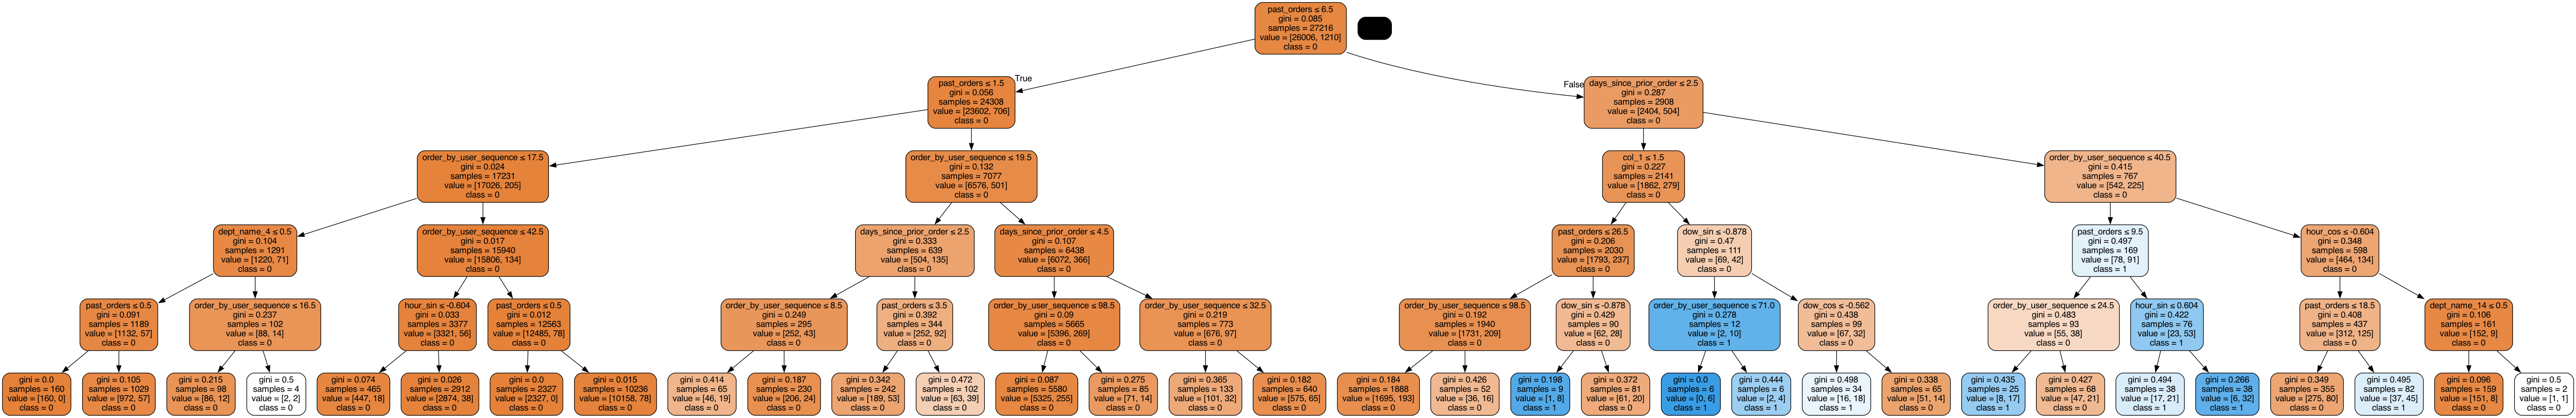

In [60]:
# Visualize
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, 
                special_characters=True, feature_names = X.columns, 
                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('pu_4models.png')
Image(graph.create_png())

In [61]:
# Try some other models

clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('conf matrix: ', metrics.confusion_matrix(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred))

conf matrix:  [[6517   25]
 [ 218   45]]
f1 score:  0.2702702702702703


In [62]:
clf = AdaBoostClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('conf matrix: ', metrics.confusion_matrix(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred))

conf matrix:  [[6539    3]
 [ 254    9]]
f1 score:  0.06545454545454546


In [63]:
clf = BaggingClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('conf matrix: ', metrics.confusion_matrix(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred))

conf matrix:  [[6481   61]
 [ 210   53]]
f1 score:  0.2811671087533157


In [64]:
clf = GradientBoostingClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('conf matrix: ', metrics.confusion_matrix(y_test, y_pred))
print('f1 score: ', metrics.f1_score(y_test, y_pred))

conf matrix:  [[6530   12]
 [ 224   39]]
f1 score:  0.24840764331210188


These f1 scores aren't high, but I'm not going to try to optimize anything here. This was all for practice so that I have a sense of what to try with a larger dataset. Move on to steps of preprocessing:
- Simply get all the correct rows and columns in a larger dataset. 
- Balance the data so that there aren't so many more 0s than 1s in the reordered column.
- Play around to discover best encoding & modeling practices. Confirm statistical relationships among features and work to reduce them to those that are most relevant.

I'll begin all of this here: https://github.com/fractaldatalearning/Capstone2/blob/main/notebooks/preprocessing1_get_manageable_df.ipynb